1DEG: A 1D String. Scattering is EG, leads are MTI.

In [19]:
import kwant
import numpy as np
import kwant.continuum
import matplotlib.pyplot as plt
import tinyarray

sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])
sigma_z = tinyarray.array([[1, 0], [0, -1]])

I_4=tinyarray.array(np.kron(sigma_0, sigma_0))
gamma_1 = tinyarray.array(np.kron(sigma_0, sigma_z))   
gamma_2 = tinyarray.array(np.kron(sigma_z, sigma_z))  
gamma_3 = tinyarray.array(np.kron(sigma_0, sigma_y))
gamma_4 = tinyarray.array(np.kron(sigma_0, sigma_x))

B=-300
g=300
las=1
c=1.0

structure=kwant.lattice.square(las,norbs=4)

def make_syst(width=50,length = 200):
    
    
    def model_MTI():
        
        def MTI_onsite(site,m):
           return m/2*gamma_1 - (4*B)/las**2 * gamma_2
        MTI_hopping_x = B/(las**2)*gamma_2 + 1j*g/(2*las)*gamma_3
        MTI_hopping_y = B/(las**2)*gamma_2 - 1j*g/(2*las)*gamma_4

        model_sym= kwant.TranslationalSymmetry(structure.vec((1,0)),structure.vec((0,-1)))
        model_1= kwant.Builder(model_sym)

        model_1[structure(0, 0)] = MTI_onsite
        model_1[kwant.builder.HoppingKind((1,0), structure)]  = MTI_hopping_x
        model_1[kwant.builder.HoppingKind((0,1), structure)]  = MTI_hopping_y

        return model_1
    
    def model_EG():

        EG_onsite    = (4*c)/las**2 * I_4
        EG_hopping_x = -c/(las**2)*I_4
        EG_hopping_y = -c/(las**2)*I_4 
       
        model_sym= kwant.TranslationalSymmetry(structure.vec((1,0)),structure.vec((0,-1)))
        model_1= kwant.Builder(model_sym)

        model_1[structure(0, 0)] = EG_onsite
        model_1[kwant.builder.HoppingKind((1,0), structure)]  = EG_hopping_x
        model_1[kwant.builder.HoppingKind((0,1), structure)]  = EG_hopping_y

        return model_1

    ########### create the scattering center

    def shape_center(site):
        x, y = site.pos
        return 0 < x <= length and 0 < y <= width

    syst= kwant.Builder()
    syst.fill(model_MTI(), shape_center,(1,1))

    ########### create the leads

    width_lead = length//5 

    lead0= kwant.Builder(kwant.TranslationalSymmetry((-1,0)))
    lead1= kwant.Builder(kwant.TranslationalSymmetry((0,1)))
    lead2= kwant.Builder(kwant.TranslationalSymmetry((0,1)))

    def shape_lead0(site):
        x, y = site.pos
        return 0 < y <= width

    def shape_lead1(site):
        x, y = site.pos
        return width_lead < x <= 2*width_lead

    def shape_lead2(site):
        x, y = site.pos
        return 3*width_lead < x <= 4*width_lead

    lead0.fill(model_EG(), shape_lead0, (0, 1))
    lead1.fill(model_EG(), shape_lead1, (width_lead+1, 0))
    lead2.fill(model_EG(), shape_lead2, (3*width_lead+1, 0))

    ########### create the six-terminal device
    for lead in [lead0,lead1,lead2, lead0.reversed(),lead2.reversed(),lead1.reversed()]:
        syst.attach_lead(lead)

    return syst.finalized()  

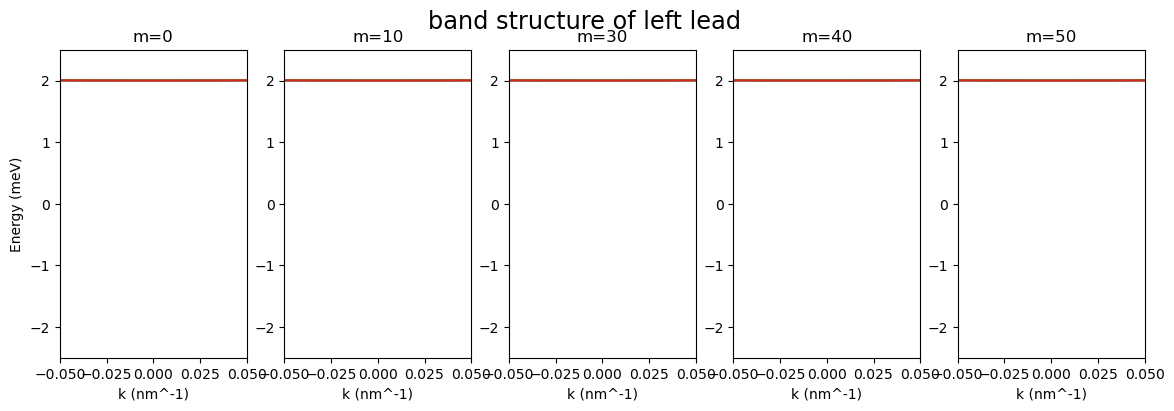

In [20]:
syst1=make_syst(width=1,length=30).leads[0]

fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize=(14, 4))
fig.suptitle('band structure of left lead', size='xx-large')
a_x=0.05
a_y=2.5
ax1.set_ylabel('Energy (meV)')
for ax in zip((ax1,ax2,ax3,ax4,ax5),(0,10,30,40,50)):
    ax[0].set_xlabel('k (nm^-1)')
    ax[0].set_ylim(-a_y,a_y)
    ax[0].set_xlim(-a_x,a_x)
    ax[0].set_title(f'm={ax[1]}')
    kwant.plotter.bands(syst1,momenta=np.linspace(-a_x, a_x, 50), ax=ax[0], params=dict(m=ax[1]));

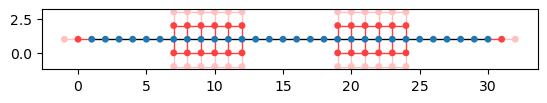

In [21]:
syst=make_syst(width=1,length=30)
kwant.plot(syst);